# Supervised evaluation of SAE representations

This notebook proposes a identifiability method based on linear regression to analyze the representations learned by SAE in audio foundation models.

In [ ]:
import pandas as pd
import os
from audIBle.eval.metrics import disentanglement_score, completeness_score

### Read the features for the current set

In [2]:
path_to_features = "/lium/corpus/vrac/tmario/VocalSet/features/concat/test/features_egemaps_vocalset.csv"
all_feat = pd.read_csv(path_to_features)
all_feat.replace("tones_trillà","trillo",inplace=True)
all_feat.replace("tones_trill","trill",inplace=True)
all_feat.replace("tones_inhaled","inhaled",inplace=True)
all_feat.replace("tones_straight","straight",inplace=True)



In [3]:
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.pyplot as plt

generate_histograms = False

if generate_histograms:
    ignore_cols = ["audio_path", "name", "singer", "exercise_type", "vocal_technique", "vowel", "audio_id"]
    cols_to_plot = [col for col in all_feat.columns if col not in ignore_cols]

    with PdfPages("all_feat_histograms.pdf") as pdf:
        for col in cols_to_plot:
            plt.figure()
            all_feat[col].hist(bins=100)
            plt.title(col)
            plt.xlabel(col)
            plt.ylabel("Frequency")
            pdf.savefig()
            plt.close()

### Extract SAE representation for each layer in each model at each sparsity level

In [4]:
import h5py
import json 
import numpy as np

exp_root = "/lium/raid-b/tmario/train/SAE/ssl"
exp_list = os.listdir(exp_root)

exp_select = [f"{i:03d}" for i in range(6)] + [f"{i:03d}" for i in range(11,16)] + [f"{i:03d}" for i in range(21,35)]
print(exp_select)
exp_list = [e for e in exp_list if e.split('_')[0] in exp_select]
dataset = "vocalset"
exp_list = [e for e in exp_list if dataset in e]

['000', '001', '002', '003', '004', '005', '011', '012', '013', '014', '015', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034']


### To save representations if needed

In [5]:
save_rep = False

In [6]:
rep_dict = {
    "ast": {"sparsity": [], "hidden": [], "latent": [], "path": [], "labels": []},
    "wavlm": {"sparsity": [], "hidden": [], "latent": [], "path": [], "labels": []},
    "mert": {"sparsity": [], "hidden": [], "latent": [], "path": [], "labels": []},
    "hubert": {"sparsity": [], "hidden": [], "latent": [], "path": [], "labels": []},
}

for exp in exp_list:
    exp_id = exp.split("_")[0]
    exp_path = os.path.join(exp_root, exp)
    cfg_path = os.path.join(exp_path, "config.json")

    with open(cfg_path,"r") as fh:
        cfg = json.load(fh)

    model_type = cfg["model"]["encoder_type"]
    sparsity = cfg["model"]["sparsity"]
    files = os.listdir(exp_path)

    rep_file = os.path.join(exp_path,[f for f in files if f.startswith("extract_rep")][0])
    sae_rep = {}
    with h5py.File(rep_file, "r") as fh:
        for k in fh.keys():
            data = fh[k][()]
            sae_rep[k] = data

    rep_dict[model_type]["hidden"].append(sae_rep["hidden"])
    rep_dict[model_type]["latent"].append(sae_rep["latent"])
    rep_dict[model_type]["sparsity"].append(sparsity)
    rep_dict[model_type]["path"].append(sae_rep["path"])

labels = sae_rep["label"]
index_map = ['belt', 'breathy', 'inhaled', 'lip_trill', 'spoken', 'straight', 'trill', 'trillo', 'vibrato', 'vocal_fry']
if save_rep:
    import pickle
    class_labels = {"test_set_labels": labels, "label_map": index_map}
    with open(f"class_labels.pkl", "wb") as f:
        pickle.dump(class_labels, f)



In [7]:
def extract_all(full_feature_set: pd.DataFrame, sae_rep: np.array, input_act: np.array, idx_layer: int, paths: np.array):
    """match eGMAPS features with SAE representations for a givent dataset

    Args:
        full_feature_set (pd.DataFrame): dataframe containing the eGMAPS features for each file of the dataset (one line per file)
        sae_rep (np.array): array containing the SAE representaiotns extracted for each file 
        idx_layer (int): index of the layer to be used in the SAE representation
        paths (np.array): list of audio files to map the SAE representation with the features

    Returns:
        _type_: _description_
    """
    path_list = np.squeeze(paths)
    filename_list = [os.path.split(p.decode("utf-8"))[-1][:-4] for p in path_list]

    sae_act_stack = []
    input_act_stack = []
    feat_stack = []
    for index, row in full_feature_set.iterrows():
        audio_id = row["audio_id"]
        idx_rep = filename_list.index(audio_id)

        sae_activations = sae_rep[idx_rep,idx_layer,0,0,:]
        sae_input = input_act[idx_rep, idx_layer,0,0,:]

        sae_act_stack.append(sae_activations)
        input_act_stack.append(sae_input)

        audio_feat = row.drop(["audio_path", "name", "singer", "exercise_type", "vocal_technique", "vowel", "audio_id"], axis=0)
        audio_feat_np = audio_feat.to_numpy()

        feat_stack.append(audio_feat_np)

    sae_act_stack = np.array(sae_act_stack)
    feat_stack = np.array(feat_stack)
    input_act_stack = np.array(input_act_stack)

    return sae_act_stack, feat_stack, input_act_stack


from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

def fit_lasso(sae_latent_stack, feat_stack, min_dim_var=0):
    ignore_cols = ["audio_path", "name", "singer", "exercise_type", "vocal_technique", "vowel", "audio_id"]
    feature_labels = [col for col in all_feat.columns if col not in ignore_cols]
    clf = linear_model.Lasso(alpha=0.1,max_iter=10000)
    scaler = StandardScaler()
    
    X = sae_latent_stack
    y = feat_stack
    # dims_keep = np.sum(X, axis=0) > 0 
    X_norm = scaler.fit_transform(X)

    dims_keep = np.var(X_norm, axis=0) >= min_dim_var
    X_norm = X_norm[:,dims_keep]
    # print(f"INFO: {X_norm.shape[-1]} dims kept in SAE activations.")
    #normalize target features as well
    y_norm = scaler.fit_transform(y)
    n_feat = y_norm.shape[-1]

    lasso_dict = {}
    all_r2=[]
    weight_matrix = np.zeros((X_norm.shape[-1], y.shape[-1]))
    for idx_feat in range(n_feat):
        new_model = clone(clf)
        new_model.fit(X_norm, y_norm[:,idx_feat])
        score = new_model.score(X_norm, y_norm[:,idx_feat])
        lasso_dict[feature_labels[idx_feat]] = {"r2": score, "weights": new_model.coef_, "sparse_weights": new_model.sparse_coef_}
        weight_matrix[:,idx_feat] = np.abs(new_model.coef_)
        all_r2.append(score)

    return weight_matrix, all_r2, feature_labels

### Fucntions to fit LASSO regressors

In [9]:
from tqdm import tqdm
def sort_with_sparsity(rep, sparsity, act):
    rep = np.array(rep)
    sparsity = np.array(sparsity)
    act = np.array(act)
    idx_srt = np.argsort(sparsity)
    sparsity_srt = sparsity[idx_srt]
    rep_srt = rep[idx_srt,...]
    act_srt = act[idx_srt,...]
    return sparsity_srt, rep_srt, act_srt


layer_index_map = {
    "ast": [6, 12],
    "wavlm": [1, 12],
    "mert": [4, 7],
    "hubert": [3, 12]
}

def fit_all(rep_dict, full_feat_set, min_dim_var=0.0, select_top_feat:int=5, metric_to_sort: str = "r2"):

    results = []
    for model_type, reps in tqdm(rep_dict.items()):
        sparsity = reps["sparsity"]
        sae_hidden = reps["latent"]
        sae_input = reps["hidden"]

        sparsity_srt, sae_srt, input_srt = sort_with_sparsity(sae_hidden, sparsity, sae_input)
        path = np.array(reps["path"])[0,:,0]
        # print(f"{sparsity_srt.shape=}\n{sae_srt.shape=}\n{path.shape=}")
        layer_indexes = layer_index_map[model_type]
        for s, sae, input_act in zip(sparsity_srt, sae_srt, input_srt):
            for idx in range(len(layer_indexes)):
                sae_latent_stack, feat_stack, sae_input_stack = extract_all(full_feat_set, sae, input_act, idx_layer=idx, paths=path)
                dci_mat, r2_score, feature_labels = fit_lasso(sae_latent_stack, feat_stack, min_dim_var=min_dim_var)
                r2_score = np.array(r2_score)
                modularity, rho, mod_avg = disentanglement_score(dci_mat)
                completeness = np.squeeze(completeness_score(dci_mat))

                # print(f"{modularity.shape=}")
                # print(f"{completeness.shape=}")
                # print(f"{rho.shape=}")
                # print(f"{r2_score.shape=}")
                # print(f"{r2_score[np.argsort(r2_score)[:5]]=}")
                # print(f"{r2_score[np.flipud(np.argsort(r2_score))[:5]]=}")
                # print(f"{completeness[np.argsort(completeness)[:5]]=}")
                # print(f"{completeness[np.flipud(np.argsort(completeness))[:5]]=}")
                # average metrics on the top-10 factors (based on R2)
                if metric_to_sort == "r2":
                    top_fact_index = np.flipud(np.argsort(r2_score))[:select_top_feat]
                elif metric_to_sort == "comp":
                    top_fact_index = np.flipud(np.argsort(completeness))[:select_top_feat]
                top_r2 = r2_score[top_fact_index]
                top_comp = completeness[top_fact_index]
                feature_labels = np.array(feature_labels)
                
                results.append({
                        "model_type": model_type,
                        "sparsity": s,
                        "layer_index": layer_indexes[idx],
                        "dci": dci_mat,
                        "r2": r2_score,
                        'top_r2': top_r2,
                        'top_comp': top_comp,
                        'modularity': np.squeeze(modularity),
                        'mod_avg': mod_avg,
                        'top_feat_labels': feature_labels[top_fact_index],
                        'feat_labels': feature_labels,
                        'rho': np.squeeze(rho),
                        "sae_latent_set": sae_latent_stack,
                        "feature_set": feat_stack,
                        "original_latent_set": sae_input_stack})
                

    df = pd.DataFrame(results)
    return df, feature_labels
                
def fit_orig(rep_dict, full_feat_set, min_dim_var=0.0, select_top_feat:int=5, metric_to_sort:str = "r2"):

    results = []
    for model_type, reps in tqdm(rep_dict.items()):
        sparsity = reps["sparsity"]
        sae_hidden = reps["latent"]
        sae_input = reps["hidden"]

        sparsity_srt, sae_srt, input_srt = sort_with_sparsity(sae_hidden, sparsity, sae_input)
        path = np.array(reps["path"])[0,:,0]
        # print(f"{sparsity_srt.shape=}\n{sae_srt.shape=}\n{path.shape=}")
        layer_indexes = layer_index_map[model_type]
        for s, sae, input_act in zip(sparsity_srt, sae_srt, input_srt):
            for idx in range(len(layer_indexes)):
                sae_latent_stack, feat_stack, sae_input_stack = extract_all(full_feat_set, sae, input_act, idx_layer=idx, paths=path)
                dci_mat, r2_score, feature_labels = fit_lasso(sae_input_stack, feat_stack, min_dim_var=min_dim_var)
                r2_score = np.array(r2_score)
                modularity, rho, mod_avg = disentanglement_score(dci_mat)
                completeness = np.squeeze(completeness_score(dci_mat))

                # average metrics on the top-10 factors (based on R2)
                if metric_to_sort == "r2":
                    top_fact_index = np.flipud(np.argsort(r2_score))[:select_top_feat]
                elif metric_to_sort == "comp":
                    top_fact_index = np.flipud(np.argsort(completeness))[:select_top_feat]
                top_fact_index = np.flipud(np.argsort(r2_score))[:select_top_feat]
                top_r2 = r2_score[top_fact_index]
                top_comp = completeness[top_fact_index]
                feature_labels = np.array(feature_labels)
                
                results.append({
                        "model_type": model_type,
                        "layer_index": layer_indexes[idx],
                        "dci": dci_mat,
                        "r2": r2_score,
                        'top_r2': top_r2,
                        'top_comp': top_comp,
                        'modularity': np.squeeze(modularity),
                        'top_feat_labels': feature_labels[top_fact_index],
                        'feat_labels': feature_labels,
                        'rho': np.squeeze(rho),
                        "mod_avg": mod_avg,
                        "sae_latent_set": sae_latent_stack,
                        "feature_set": feat_stack,
                        "original_latent_set": sae_input_stack})
            break
                

    df = pd.DataFrame(results)
    return df, feature_labels



### EXtract and sort on R2

In [10]:
run_extract = False
import pickle
if not run_extract:
    df_res_r2 = pd.read_pickle("./saved/df_res_r2.pkl")
    df_orig_r2 = pd.read_pickle("./saved/df_orig_r2.pkl")
    with open("./saved/feature_labels.pkl", 'rb') as fh:
        feature_labels = pickle.load(fh)


In [11]:
if run_extract:
    df_res_r2, feature_labels = fit_all(rep_dict=rep_dict, full_feat_set=all_feat, min_dim_var=0.0, select_top_feat=10, metric_to_sort="r2")
    df_res_r2.to_pickle("./saved/df_res_r2.pkl")
    with open("./saved/feature_labels.pkl", "wb") as fh:
        pickle.dump(feature_labels, fh)


In [12]:
if run_extract:
    df_orig_r2, _ = fit_orig(rep_dict=rep_dict, full_feat_set=all_feat, min_dim_var=0.0, select_top_feat=10, metric_to_sort="r2")
    df_orig_r2.to_pickle("./saved/df_orig_r2.pkl")


### Visualize disentanglement metrics vs. sparsity

layer_indexes=array([ 6, 12])
layer_indexes=array([ 1, 12])
layer_indexes=array([4, 7])
layer_indexes=array([ 3, 12])


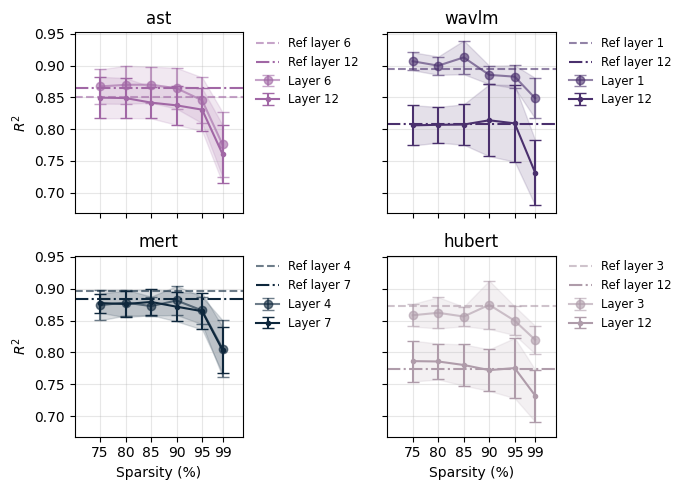

In [13]:
import matplotlib.pyplot as plt
import numpy as np

model_types = df_res_r2['model_type'].unique()
layer_indexes = df_res_r2['layer_index'].unique()
# markers = ['o', 's', '^', 'D', 'v', 'x', '*', 'P', 'h', '+']
colors = plt.cm.tab10.colors

palette = ["#AF9CAA", "#A167A5", "#4A306D", "#0E273C", "#E8D7F1"]
markers = ["o", ".","d", "s","x", "+","^", "v"]

f, axs = plt.subplots(2, 2, figsize=(7, 5), layout='tight', sharex=True, sharey=True)
axs_flat = np.ravel(axs)
# Create individual plots for each model
for i, model in enumerate(model_types):
    # Create a new figure for each model
    if model == "ast":
        color = palette[1]
    elif model == "wavlm":
        color = palette[2]
    elif model == "hubert":
        color = palette[0]
    elif model == "mert":
        color = palette[3]
    # color = palette[i]
    llinestyles = ["--", "-."]
    marker = markers[i*2:(i+1)*2]
    ax = axs_flat[i]
    layer_indexes = df_res_r2.loc[df_res_r2["model_type"] == model]["layer_index"].unique()
    print(f"{layer_indexes=}")
    for j, layer in enumerate(layer_indexes):
        # print(f"{j=}")
        df_sel = df_res_r2[(df_res_r2['model_type'] == model) & (df_res_r2['layer_index'] == layer)]

        df_orig_sel = df_orig_r2[(df_orig_r2['model_type'] == model) & (df_orig_r2['layer_index'] == layer)]
        if not df_sel.empty:
            sparsity = df_sel['sparsity'].values * 100
            r2_mean = df_sel['top_r2'].apply(lambda x: np.mean(x)).values
            r2_std = df_sel['top_r2'].apply(lambda x: np.std(x)).values

            r2_mean_o = df_orig_sel['top_r2'].apply(lambda x: np.mean(x)).values
            r2_std_o = df_orig_sel['top_r2'].apply(lambda x: np.std(x)).values
            
            # Get feat_labels safely
            if 'top_feat_labels' in df_sel.columns:
                feat_labels = df_sel['top_feat_labels'].values
            else:
                feat_labels = None
            
            # Plot R2 data
            # Plot mean completeness with error bars and fill for std
            # ax.plot(
            #     sparsity, comp_mean,
            #     marker=marker[j],
            #     color=color,
            #     alpha= 0.5 if j == 0 else 1,
            #     linestyle=' ',
            #     # label=f"layer {layer}",
            #     label= f"{model} - Layer {layer}"
            # )            
            ax.errorbar(
                sparsity, r2_mean, yerr=r2_std,
                marker=markers[j % len(markers)],
                color=color,
                alpha= 0.6 if j == 0 else 1,
                linestyle='-',
                # label=f"layer {layer}",
                capsize=4,
                label= f"Layer {layer}"
            )
            ax.fill_between(
                sparsity,
                r2_mean - r2_std,
                r2_mean + r2_std,
                color=color,
                alpha=0.15
            )

            # ax.set_title(f"Layer {layer}")
            
            # Draw horizontal lines for r2_mean_o across the full x-axis range
            for y, yerr in zip(r2_mean_o, r2_std_o):
                ax.axhline(y, color=color, linestyle=llinestyles[j], alpha=0.6 if j == 0 else 1, label=f'Ref layer {layer}')
                # Optionally, add a shaded area for std
                # ax.fill_between(ax.get_xlim(), y - yerr, y + yerr, color=colors[j % len(colors)], alpha=0.15)
            # Only add legend to the first subplot, outside the axes

            ax.legend(
                ncol=1,
                loc='upper left',
                bbox_to_anchor=(1.05, 1),
                fontsize='small',
                frameon=False,
                borderaxespad=0.
            )
            ax.set_title(f"{model}")
            ax.grid(True, alpha=0.3)
            ax.set_xlim([70,103])
            ax.set_xticks([75, 80, 85, 90, 95, 99])
            ax.set_xticklabels([f"{s}" for s in [75, 80, 85, 90, 95, 99]])

            
    
# Customize the plot
axs[0,0].set_ylabel(r"$R^2$")
axs[1,0].set_ylabel(r"$R^2$")
axs[1,0].set_xlabel('Sparsity (%)')
axs[1,1].set_xlabel('Sparsity (%)')

# ax.set_title(f'Mean $R^2$ vs Sparsity - ', fontsize=14, fontweight='bold')
# ax.legend(loc='best')

# Show each plot individually
plt.show()
    
    # Optional: Add a small pause between plots (uncomment if needed)
    # import time
    # time.sleep(0.5)

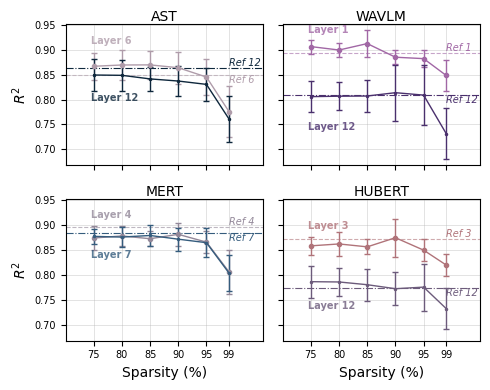

In [14]:
import matplotlib.pyplot as plt
import numpy as np

model_types = df_res_r2['model_type'].unique()
layer_indexes = df_res_r2['layer_index'].unique()

palette = ["#AF9CAA", "#A167A5", "#4A306D", "#0E273C", "#E8D7F1"]
palette = [
    "#AF9CAA",  # muted lavender
    "#0E273C",  # dark blue
    "#A167A5",  # purple
    "#4A306D",  # deep purple
    "#938899",  # light lavender
    "#355C7D",  # blue-grey
    "#B07379",  # coral pink   
    "#6C5B7B"   # muted violet
]
markers = ["o", ".", "d", "s", "x", "+", "^", "v"]

f, axs = plt.subplots(2, 2, figsize=(5, 4), layout='tight', sharex=True, sharey=True)
axs_flat = np.ravel(axs)
cnt = 0
for i, model in enumerate(model_types):
    # if model == "ast":
    #     color = palette[1]
    # elif model == "wavlm":
    #     color = palette[2]
    # elif model == "hubert":
    #     color = palette[0]
    # elif model == "mert":
    #     color = palette[3]
    llinestyles = ["--", "-."]
    marker = markers[i*2:(i+1)*2]
    ax = axs_flat[i]
    layer_indexes = df_res_r2.loc[df_res_r2["model_type"] == model]["layer_index"].unique()
    for j, layer in enumerate(layer_indexes):
        df_sel = df_res_r2[(df_res_r2['model_type'] == model) & (df_res_r2['layer_index'] == layer)]
        df_orig_sel = df_orig_r2[(df_orig_r2['model_type'] == model) & (df_orig_r2['layer_index'] == layer)]
        if not df_sel.empty:
            sparsity = df_sel['sparsity'].values * 100
            r2_mean = df_sel['top_r2'].apply(lambda x: np.mean(x)).values
            r2_std = df_sel['top_r2'].apply(lambda x: np.std(x)).values

            r2_mean_o = df_orig_sel['top_r2'].apply(lambda x: np.mean(x)).values
            r2_std_o = df_orig_sel['top_r2'].apply(lambda x: np.std(x)).values

            # Plot errorbar
            color = palette[cnt]
            line = ax.errorbar(
                sparsity, r2_mean, yerr=r2_std,
                marker=markers[j % len(markers)],
                color=color,
                # alpha=0.6 if j == 0 else 1,
                linestyle='-',
                capsize=2,
                markersize=3,
                linewidth=1,
            )
            # ax.fill_between(
            #     sparsity,
            #     r2_mean - r2_std,
            #     r2_mean + r2_std,
            #     color=color,
            #     alpha=0.10,
            #     linewidth=0
            # )
            # Add text label at the last point of the line
            if len(sparsity) > 0:
                ax.text(
                    sparsity[0] - 0.5, r2_mean[0] + max(r2_std) + 0.001 if j == 0 else r2_mean[0] - max(r2_std) - 0.001,
                    f"Layer {layer}",
                    color=color,
                    fontsize=7,
                    va='center',
                    ha='left',
                    alpha=0.8,
                    fontweight='bold'
                )
            # Reference line
            for y, yerr in zip(r2_mean_o, r2_std_o):
                ax.axhline(y, color=color, linestyle=llinestyles[j], alpha=0.6 if j == 0 else 1, linewidth=0.8)
                # Add text label for reference line
                if model == "ast":
                    ax.text(
                        sparsity[-1], y+0.01 if j == 1 else y-0.01,
                        f"Ref {layer}",
                        color=color,
                        fontsize=7,
                        va='center',
                        ha='left',
                        # alpha=0.6 if j == 0 else 1,
                        fontstyle='italic'
                    )
                else:
                    ax.text(
                        sparsity[-1], y+0.01 if j == 0 else y-0.01,
                        f"Ref {layer}",
                        color=color,
                        fontsize=7,
                        va='center',
                        ha='left',
                        # alpha=0.6 if j == 0 else 1,
                        fontstyle='italic'
                    )
            cnt+=1
    ax.set_title(f"{model.upper()}", fontsize=10, pad=2)
    ax.grid(True, alpha=0.5, linewidth=0.5)
    ax.set_xlim([70, 105])
    ax.set_xticks([75, 80, 85, 90, 95, 99])
    ax.set_xticklabels([f"{s}" for s in [75, 80, 85, 90, 95, 99]], fontsize=7)
    ax.tick_params(axis='y', labelsize=7)
    ax.tick_params(axis='x', labelsize=7)

axs[0,0].set_ylabel(r"$R^2$", fontsize=10)
axs[1,0].set_ylabel(r"$R^2$", fontsize=10)
axs[1,0].set_xlabel('Sparsity (%)', fontsize=10)
axs[1,1].set_xlabel('Sparsity (%)', fontsize=10)

# plt.subplots_adjust(wspace=0.15, hspace=0.15, bottom=0.18, left=0.12, right=0.98, top=0.95)
f.savefig('./figs/r2_eval.pdf', transparent=True)
plt.show()


# completeness as sorting metric

In [15]:
if not run_extract:
    df_res_comp = pd.read_pickle("./saved/df_res_comp.pkl")
    df_orig_comp = pd.read_pickle("./saved/df_orig_comp.pkl")

In [16]:
if run_extract:
    df_res_comp, feature_labels = fit_all(rep_dict=rep_dict, full_feat_set=all_feat, min_dim_var=0., select_top_feat=10, metric_to_sort="comp")
    df_res_comp.to_pickle("./saved/df_res_comp.pkl")


In [17]:
if run_extract:
    df_orig_comp, _ = fit_orig(rep_dict=rep_dict, full_feat_set=all_feat, min_dim_var=0., select_top_feat=10, metric_to_sort="comp")
    df_orig_comp.to_pickle("./saved/df_orig_comp.pkl")


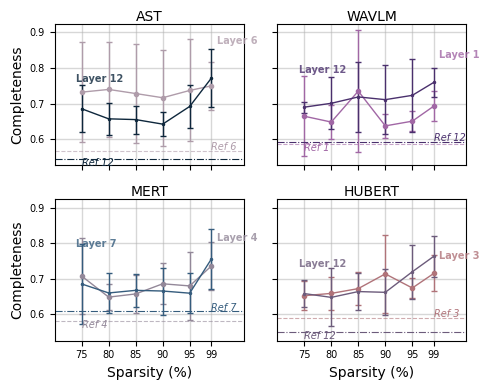

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model_types = df_res_r2['model_type'].unique()
layer_indexes = df_res_r2['layer_index'].unique()

palette = ["#AF9CAA", "#A167A5", "#4A306D", "#0E273C", "#E8D7F1"]
palette = [
    "#AF9CAA",  # muted lavender
    "#0E273C",  # dark blue
    "#A167A5",  # purple
    "#4A306D",  # deep purple
    "#938899",  # light lavender
    "#355C7D",  # blue-grey
    "#B07379",  # coral pink   
    "#6C5B7B"   # muted violet
]
markers = ["o", ".", "d", "s", "x", "+", "^", "v"]

f, axs = plt.subplots(2, 2, figsize=(5, 4), layout='tight', sharex=True, sharey=True)
axs_flat = np.ravel(axs)
cnt = 0
for i, model in enumerate(model_types):
    # if model == "ast":
    #     color = palette[1]
    # elif model == "wavlm":
    #     color = palette[2]
    # elif model == "hubert":
    #     color = palette[0]
    # elif model == "mert":
    #     color = palette[3]
    llinestyles = ["--", "-."]
    marker = markers[i*2:(i+1)*2]
    ax = axs_flat[i]
    layer_indexes = df_res_r2.loc[df_res_r2["model_type"] == model]["layer_index"].unique()
    for j, layer in enumerate(layer_indexes):
        df_sel = df_res_r2[(df_res_r2['model_type'] == model) & (df_res_r2['layer_index'] == layer)]
        df_orig_sel = df_orig_r2[(df_orig_r2['model_type'] == model) & (df_orig_r2['layer_index'] == layer)]
        if not df_sel.empty:
            sparsity = df_sel['sparsity'].values * 100
            comp_mean = df_sel['top_comp'].apply(lambda x: np.mean(x)).values
            comp_std = df_sel['top_comp'].apply(lambda x: np.std(x)).values

            comp_mean_o = df_orig_sel['top_comp'].apply(lambda x: np.mean(x)).values
            comp_std_o = df_orig_sel['top_comp'].apply(lambda x: np.std(x)).values

            # Plot errorbar
            color = palette[cnt]
            line = ax.errorbar(
                sparsity, comp_mean, yerr=comp_std,
                marker=markers[j % len(markers)],
                color=color,
                # alpha=0.6 if j == 0 else 1,
                linestyle='-',
                capsize=2,
                markersize=3,
                linewidth=1,
            )
            # ax.fill_between(
            #     sparsity,
            #     comp_mean - comp_std,
            #     comp_mean + comp_std,
            #     color=color,
            #     alpha=0.10,
            #     linewidth=0
            # )
            # Add text label at the last point of the line
            if len(sparsity) > 0:
                ax.text(
                    sparsity[0] - 1 if j == 1 else sparsity[-1] + 1,
                    comp_mean[0] + max(comp_std) + 0.001, #if j == 0 else comp_mean[0] - max(comp_std) - 0.001,
                    f"Layer {layer}",
                    color=color,
                    fontsize=7,
                    va='center',
                    ha='left',
                    alpha=0.8,
                    fontweight='bold'
                )
            # Reference line
            for y, yerr in zip(comp_mean_o, comp_std_o):
                ax.axhline(y, color=color, linestyle=llinestyles[j], alpha=0.6 if j == 0 else 1, linewidth=0.8)
                # Add text label for reference line
                if model in ["wavlm", "mert"]:
                    ax.text(
                        sparsity[-1] if j == 1 else sparsity[0], 
                        y+0.01 if j == 1 else y-0.01,
                        f"Ref {layer}",
                        color=color,
                        fontsize=7,
                        va='center',
                        ha='left',
                        # alpha=0.6 if j == 0 else 1,
                        fontstyle='italic'
                    )
                else:
                    ax.text(
                        sparsity[-1] if j == 0 else sparsity[0], 
                        y+0.01 if j == 0 else y-0.01,
                        f"Ref {layer}",
                        color=color,
                        fontsize=7,
                        va='center',
                        ha='left',
                        # alpha=0.6 if j == 0 else 1,
                        fontstyle='italic'
                    )
            cnt+=1
    ax.set_title(f"{model.upper()}", fontsize=10, pad=2)
    ax.grid(True, alpha=0.5, linewidth=0.5)
    ax.set_xlim([70, 105])
    ax.set_xticks([75, 80, 85, 90, 95, 99])
    ax.set_xticklabels([f"{s}" for s in [75, 80, 85, 90, 95, 99]], fontsize=7)
    ax.tick_params(axis='y', labelsize=7)
    ax.tick_params(axis='x', labelsize=7)

axs[0,0].set_ylabel(r"Completeness", fontsize=10)
axs[1,0].set_ylabel(r"Completeness", fontsize=10)
axs[1,0].set_xlabel('Sparsity (%)', fontsize=10)
axs[1,1].set_xlabel('Sparsity (%)', fontsize=10)
f.savefig('./figs/comp_eval.pdf', transparent=True)
# plt.subplots_adjust(wspace=0.15, hspace=0.15, bottom=0.18, left=0.12, right=0.98, top=0.95)
plt.show()


layer_indexes=array([ 6, 12])
layer_indexes=array([ 1, 12])
layer_indexes=array([4, 7])
layer_indexes=array([ 3, 12])


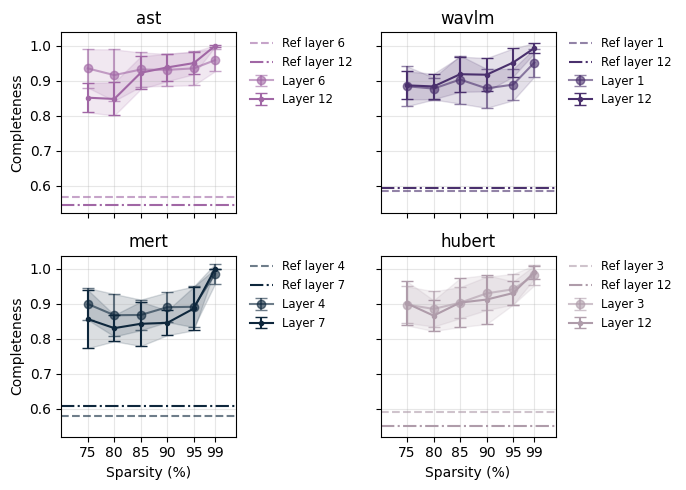

In [19]:
import matplotlib.pyplot as plt
import numpy as np

model_types = df_res_r2['model_type'].unique()
layer_indexes = df_res_r2['layer_index'].unique()
# markers = ['o', 's', '^', 'D', 'v', 'x', '*', 'P', 'h', '+']
colors = plt.cm.tab10.colors

palette = ["#AF9CAA", "#A167A5", "#4A306D", "#0E273C", "#E8D7F1"]
markers = ["o", ".","d", "s","x", "+","^", "v"]

f, axs = plt.subplots(2, 2, figsize=(7, 5), layout='tight', sharex=True, sharey=True)
axs_flat = np.ravel(axs)
# Create individual plots for each model
for i, model in enumerate(model_types):
    # Create a new figure for each model
    if model == "ast":
        color = palette[1]
    elif model == "wavlm":
        color = palette[2]
    elif model == "hubert":
        color = palette[0]
    elif model == "mert":
        color = palette[3]
    # color = palette[i]
    llinestyles = ["--", "-."]
    marker = markers[i*2:(i+1)*2]
    ax = axs_flat[i]
    layer_indexes = df_res_comp.loc[df_res_comp["model_type"] == model]["layer_index"].unique()
    print(f"{layer_indexes=}")
    for j, layer in enumerate(layer_indexes):
        # print(f"{j=}")
        df_sel = df_res_comp[(df_res_comp['model_type'] == model) & (df_res_comp['layer_index'] == layer)]
        df_orig_sel = df_orig_comp[(df_orig_comp['model_type'] == model) & (df_orig_comp['layer_index'] == layer)]
        if not df_sel.empty:
            sparsity = df_sel['sparsity'].values
            r2_mean = df_sel['top_r2'].apply(lambda x: np.mean(x)).values
            r2_std = df_sel['top_r2'].apply(lambda x: np.std(x)).values
            comp_mean = df_sel['top_comp'].apply(lambda x: np.mean(x)).values
            comp_std = df_sel['top_comp'].apply(lambda x: np.std(x)).values

            r2_mean_o = df_orig_sel['top_r2'].apply(lambda x: np.mean(x)).values
            r2_std_o = df_orig_sel['top_r2'].apply(lambda x: np.std(x)).values
            comp_mean_o = df_orig_sel['top_comp'].apply(lambda x: np.mean(x)).values
            comp_std_o = df_orig_sel['top_comp'].apply(lambda x: np.std(x)).values
            
            # Get feat_labels safely
            if 'top_feat_labels' in df_sel.columns:
                feat_labels = df_sel['top_feat_labels'].values
            else:
                feat_labels = None
            
            # Plot R2 data
            # Plot mean completeness with error bars and fill for std
            # ax.plot(
            #     sparsity, comp_mean,
            #     marker=marker[j],
            #     color=color,
            #     alpha= 0.5 if j == 0 else 1,
            #     linestyle=' ',
            #     # label=f"layer {layer}",
            #     label= f"{model} - Layer {layer}"
            # )            
            ax.errorbar(
                sparsity*100, comp_mean, yerr=comp_std,
                marker=markers[j % len(markers)],
                color=color,
                alpha= 0.6 if j == 0 else 1,
                linestyle='-',
                # label=f"layer {layer}",
                capsize=4,
                label= f"Layer {layer}"
            )
            ax.fill_between(
                sparsity*100,
                comp_mean - comp_std,
                comp_mean + comp_std,
                color=color,
                alpha=0.15
            )

            # ax.set_title(f"Layer {layer}")
            
            # Draw horizontal lines for comp_mean_o across the full x-axis range
            for y, yerr in zip(comp_mean_o, comp_std_o):
                ax.axhline(y, color=color, linestyle=llinestyles[j], alpha=0.6 if j == 0 else 1, label=f'Ref layer {layer}')
                # Optionally, add a shaded area for std
                # ax.fill_between(ax.get_xlim(), y - yerr, y + yerr, color=colors[j % len(colors)], alpha=0.15)
            # Only add legend to the first subplot, outside the axes

            ax.legend(
                ncol=1,
                loc='upper left',
                bbox_to_anchor=(1.05, 1),
                fontsize='small',
                frameon=False,
                borderaxespad=0.
            )
            ax.set_title(f"{model}")
            ax.grid(True, alpha=0.3)
            ax.set_xlim([70,103])
            ax.set_xticks([75, 80, 85, 90, 95, 99])
            ax.set_xticklabels([f"{s}" for s in [75, 80, 85, 90, 95, 99]])

            
    
# Customize the plot
axs[0,0].set_ylabel(r"Completeness")
axs[1,0].set_ylabel(r"Completeness")
axs[1,0].set_xlabel('Sparsity (%)')
axs[1,1].set_xlabel('Sparsity (%)')

# ax.set_title(f'Mean $R^2$ vs Sparsity - ', fontsize=14, fontweight='bold')
# ax.legend(loc='best')

# Show each plot individually
plt.show()
    
    # Optional: Add a small pause between plots (uncomment if needed)
    # import time
    # time.sleep(0.5)

### Modularity

In [20]:
# df_res, feature_labels = fit_all(rep_dict=rep_dict, full_feat_set=all_feat, min_dim_var=0.0, select_top_feat=10, metric_to_sort="comp")


In [21]:
# df_orig, _ = fit_orig(rep_dict=rep_dict, full_feat_set=all_feat, min_dim_var=0.8, select_top_feat=10, metric_to_sort="comp")

In [22]:
# import matplotlib.pyplot as plt
# import numpy as np

# model_types = df_res['model_type'].unique()
# layer_indexes = df_res['layer_index'].unique()
# markers = ['o', 's', '^', 'D', 'v', 'x', '*', 'P', 'h', '+']
# colors = plt.cm.tab10.colors

# # Create individual plots for each model
# for i, model in enumerate(model_types):
#     # Create a new figure for each model
#     f, ax = plt.subplots(1, 2, figsize=(10, 5), layout='tight', sharey=True)
#     layer_indexes = df_res.loc[df_res["model_type"] == model]["layer_index"].unique()
#     print(f"{layer_indexes=}")
#     for j, layer in enumerate(layer_indexes):
#         print(f"{j=}")
#         df_sel = df_res[(df_res['model_type'] == model) & (df_res['layer_index'] == layer)]
#         df_orig_sel = df_orig[(df_orig['model_type'] == model) & (df_orig['layer_index'] == layer)]
#         if not df_sel.empty:
#             sparsity = df_sel['sparsity'].values
#             print(f"{df_sel['mod_avg'].values=}")
#             mod_mean = np.mean(df_sel['modularity'].values * df_sel['rho'].values)
#             print(f"{mod_mean.shape=}")
#             mod_std = np.std(df_sel['modularity'].values * df_sel['rho'].values)

#             mod_mean_o = np.mean(df_orig_sel['modularity'].values * df_orig_sel['rho'].values)
#             mod_std_o = np.std(df_orig_sel['modularity'].values * df_orig_sel['rho'].values)
            
#             # Get feat_labels safely
#             if 'top_feat_labels' in df_sel.columns:
#                 feat_labels = df_sel['top_feat_labels'].values
#             else:
#                 feat_labels = None
            
#             # Plot R2 data
#             # Plot mean completeness with error bars and fill for std
#             ax[j].errorbar(
#                 sparsity, mod_mean, yerr=mod_std,
#                 marker=markers[j % len(markers)],
#                 color=colors[j % len(colors)],
#                 linestyle='-',
#                 label=f"layer {layer}",
#                 capsize=4
#             )
#             ax[j].fill_between(
#                 sparsity,
#                 mod_mean - mod_std,
#                 mod_mean + mod_std,
#                 color=colors[j % len(colors)],
#                 alpha=0.15
#             )

#             ax[j].set_title(f"Layer {layer}")
            
#             # Draw horizontal lines for comp_mean_o across the full x-axis range
#             for y, yerr in zip(mod_mean_o, mod_std_o):
#                 ax[j].axhline(y, color=colors[j % len(colors)], linestyle='--', alpha=0.7)
#                 # Optionally, add a shaded area for std
#                 # ax[j].fill_between(ax[j].get_xlim(), y - yerr, y + yerr, color=colors[j % len(colors)], alpha=0.15)
            
#             ax[j].grid(True, alpha=0.3)
#             ax[j].set_xlabel('Sparsity')
            
    
#     # Customize the plot
#     ax[0].set_ylabel(r"Modularity" + f" - {model}")
   
#     # ax.set_title(f'Mean $R^2$ vs Sparsity - ', fontsize=14, fontweight='bold')
#     # ax.legend(loc='best')
    
#     # Show each plot individually
#     plt.show()
    
#     # Optional: Add a small pause between plots (uncomment if needed)
#     # import time
#     # time.sleep(0.5)